In [1]:
%cd ..

/home/kimsin98/Adolescent/StructFunc


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
idx = pd.IndexSlice
SEED = 69

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='ticks')
colors = sns.color_palette()

In [3]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from utils import abcd, plotting, residual

covariates = abcd.load_covariates(covars=['interview_age', 'sex', 'hisp'],
                                  simple_race=True)

In [4]:
def within_between(flat_tril):
    matrix = plotting.unflatten_tril(flat_tril)
    within = np.nanmean(matrix.diagonal())
    between = np.nanmean(matrix[np.tril_indices_from(matrix, k=-1)])
    return pd.Series([within, between], index=['within', 'between'])

# Functional Connectivity

In [5]:
fcon, fc_extra = abcd.load_mri_data('fcon', path=abcd.OUT_PATH / 'fcon-device-software.csv')
fcon = abcd.filter_siblings(fcon, random_state=SEED)
fc_extra = fc_extra.loc[fcon.index]

print(fcon.index.get_level_values(0).nunique(), 'subjects')

3694 subjects


In [6]:
age_month = covariates.loc[fcon.index, 'interview_age']
age_month_diff = age_month.groupby(level=0).diff().dropna().droplevel(1)

## Covariates

### Age

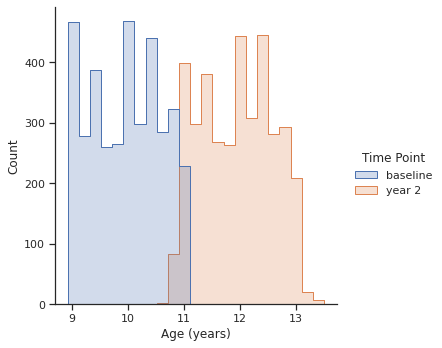

In [7]:
data_age = ((age_month / 12).reset_index()
            .rename(columns={'eventname':'Time Point'})
            .replace({abcd.EVENTS[0]:'baseline', abcd.EVENTS[1]:'year 2'}))

g = sns.displot(data_age, x='interview_age', hue='Time Point', element='step')
g.set_xlabels('Age (years)')
plt.show()

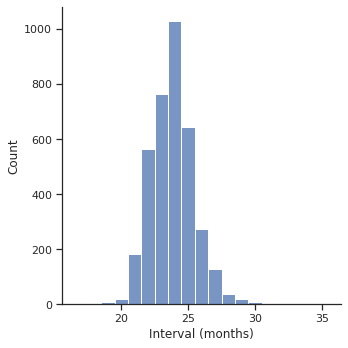

In [8]:
g = sns.displot(age_month_diff, discrete=True)
g.set_xlabels('Interval (months)')
plt.show()

### Sex

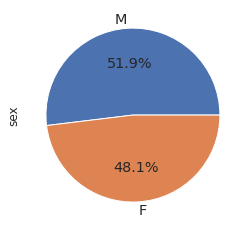

In [9]:
sex = covariates.loc[fcon.index, 'sex'].xs(abcd.EVENTS[1], level='eventname')

ax = sex.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'large'})
plt.show()

### Race

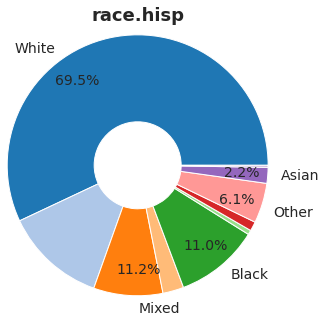

In [10]:
racehisp = covariates.loc[fcon.index, ['race', 'hisp']].xs(abcd.EVENTS[1], level='eventname')

outer_counts = racehisp.dropna()['race'].value_counts()
inner_counts = racehisp.value_counts(sort=False).loc[outer_counts.index, ['No', 'Yes']]
inner_colors = plt.get_cmap('tab20')(np.arange(len(inner_counts)))

fig, ax = plt.subplots()
ax.pie(outer_counts, radius=1.5, wedgeprops={'width':0, 'edgecolor':'w'},
       labels=outer_counts.index, autopct='%1.1f%%', pctdistance=0.8,
       textprops={'size':14})
ax.pie(inner_counts, radius=1.5, wedgeprops={'width':1, 'edgecolor':'w'},
       colors=inner_colors)
ax.set_title('race.hisp', pad=36, fontdict={'weight':'bold', 'size':18})
plt.show()

### Mean Framewise Displacement

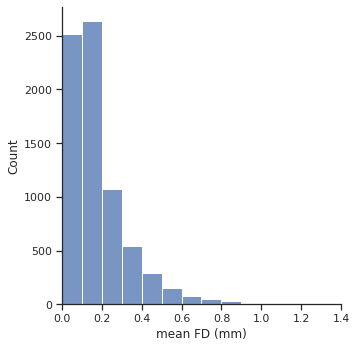

In [11]:
g = sns.displot(fc_extra['meanmotion'], binwidth=0.1, binrange=(0, 1.4))
g.set(xlim=(0, 1.4))
g.set_xlabels('mean FD (mm)')
plt.show()

## Difference

### Group

In [12]:
fcon_baseline = fcon.xs(abcd.EVENTS[0], level='eventname')
fcon_year2 = fcon.xs(abcd.EVENTS[1], level='eventname')

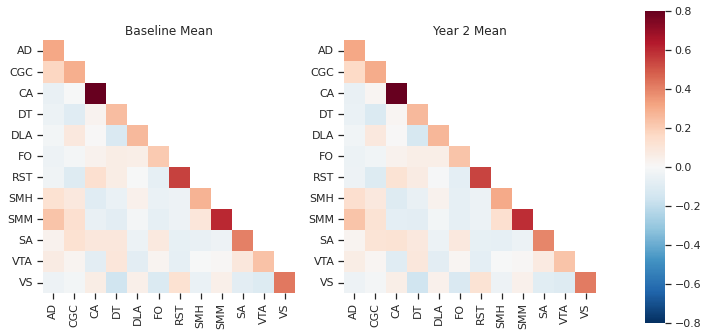

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(10,5),
                        gridspec_kw={'width_ratios': [1, 1, 0.08]})

plotting.plot_fcon(fcon_baseline.mean(), ax=axs[0],
                   cmap='RdBu_r', vmin=-0.8, vmax=0.8, cbar=False)
axs[0].set_title('Baseline Mean')

plotting.plot_fcon(fcon_year2.mean(), ax=axs[1],
                   cmap='RdBu_r', vmin=-0.8, vmax=0.8, cbar_ax=axs[2])
axs[1].set_title('Year 2 Mean')
plt.tight_layout()
plt.show()

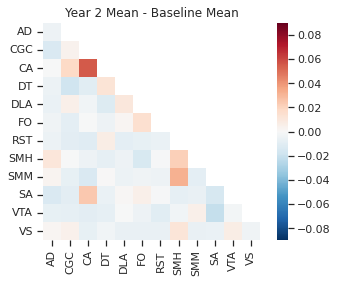

In [14]:
ax = plotting.plot_fcon(fcon_year2.mean() - fcon_baseline.mean(),
                        cmap='RdBu_r', vmin=-0.09, vmax=0.09)
ax.set_title('Year 2 Mean - Baseline Mean')
plt.show()

### Longitudinal

In [15]:
dFC = (fcon.groupby(level=0).diff().dropna().droplevel(1)
       .divide(age_month_diff / 12, axis=0))

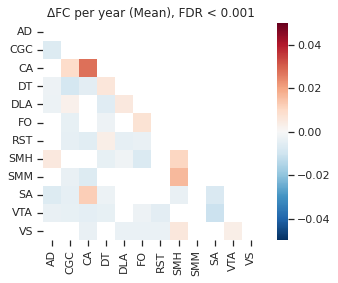

In [16]:
tstats, pvals = stats.ttest_1samp(dFC, 0, nan_policy='omit')
ttest_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

ax = plotting.plot_fcon(dFC.mean().mask(~ttest_fdr[0], np.nan),
                        cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title('ΔFC per year (Mean), FDR < 0.001')
plt.show()

#### Within-Between

In [17]:
dFC_withbetw = (fcon.apply(within_between, axis=1)
                .groupby(level=0).diff().dropna().droplevel(1)
                .divide(age_month_diff / 12, axis=0))

In [18]:
with_t_p = stats.ttest_1samp(dFC_withbetw['within'], 0, alternative='greater')
betw_t_p = stats.ttest_1samp(dFC_withbetw['between'], 0, alternative='less')

print('mean within FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=dFC_withbetw['within'].mean(), p=with_t_p[1]))
print('mean between FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=dFC_withbetw['between'].mean(), p=betw_t_p[1]))

mean within FC change = +0.0031, p = 7.4E-12
mean between FC change = -0.0017, p = 6.5E-37


### Residualized

In [19]:
confounds = fc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
fcon_resid = residual.residualize(fcon, sm.OLS, confounds, n_procs=4)

In [20]:
dFC_resid = (fcon_resid.groupby(level=0).diff().dropna().droplevel(1)
             .divide(age_month_diff / 12, axis=0))

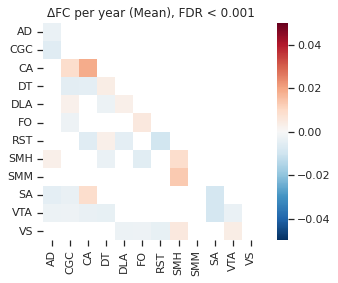

In [21]:
tstats, pvals = stats.ttest_1samp(dFC_resid, 0, nan_policy='omit')
ttest_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

ax = plotting.plot_fcon(dFC_resid.mean().mask(~ttest_fdr[0], np.nan),
                        cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title('ΔFC per year (Mean), FDR < 0.001')
plt.show()

#### Within-Between

In [22]:
dFC_resid_withbetw = (fcon_resid.apply(within_between, axis=1)
                      .groupby(level=0).diff().dropna().droplevel(1)
                      .divide(age_month_diff / 12, axis=0))

In [23]:
with_t_p = stats.ttest_1samp(dFC_resid_withbetw['within'], 0, alternative='greater')
betw_t_p = stats.ttest_1samp(dFC_resid_withbetw['between'], 0, alternative='less')

print('mean within FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=dFC_resid_withbetw['within'].mean(), p=with_t_p[1]))
print('mean between FC change = {b:+.4f}, p = {p:.1E}'
      .format(b=dFC_resid_withbetw['between'].mean(), p=betw_t_p[1]))

mean within FC change = +0.0005, p = 1.2E-01
mean between FC change = -0.0009, p = 2.3E-13


### Linear Mixed Effects (LONG)

In [ ]:
exog = (fc_extra[['meanmotion']].join(age_month / 12)
        .join(covariates[['sex', 'race', 'hisp']]))
groups = fcon.index.to_frame()[abcd.INDEX[0]]

with warnings.catch_warnings():
    warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
    fcon_lme = residual.residualize(
        fcon, sm.MixedLM, exog,
        groups=groups, method=['bfgs', 'cg', 'nm'],
        return_results=True, n_procs=4
    )

In [48]:
fcon_beta = fcon_lme.apply(lambda r: r.params['interview_age'])
pvals = fcon_lme.apply(lambda r: r.pvalues['interview_age'])
p_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

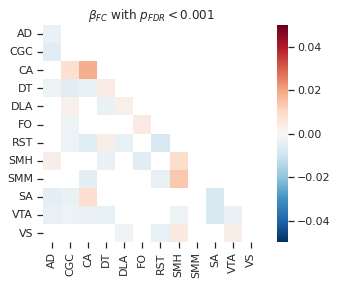

In [52]:
ax = plotting.plot_fcon(fcon_beta.mask(~p_fdr[0], np.nan),
                        cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title(r'$\beta_{FC}$ with $p_{FDR} < 0.001$')
plt.show()

#### Within-Between

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
    fcon_withbetw_lme = residual.residualize(
        fcon.apply(within_between, axis=1), sm.MixedLM, exog,
        groups=groups, method=['bfgs', 'cg', 'nm'],
        return_results=True
    )

In [61]:
print('Beta within FC = {b:+.4f}, p = {p:.1E}'
      .format(b=fcon_withbetw_lme.loc['within'].params['interview_age'],
              p=fcon_withbetw_lme.loc['within'].pvalues['interview_age']))
print('Beta between FC = {b:+.4f}, p = {p:.1E}'
      .format(b=fcon_withbetw_lme.loc['between'].params['interview_age'],
              p=fcon_withbetw_lme.loc['between'].pvalues['interview_age']))

Beta within FC = +0.0008, p = 6.5E-02
Beta between FC = -0.0010, p = 2.0E-17


# Structural Connectivity

In [15]:
scon, sc_extra = abcd.load_mri_data('scon', path=abcd.OUT_PATH / 'scon-device-software.csv')
scon = abcd.filter_siblings(scon, random_state=SEED)
sc_extra = sc_extra.loc[scon.index]

print(scon.index.get_level_values(0).nunique(), 'subjects')

4090 subjects


In [16]:
age_month = covariates.loc[scon.index, 'interview_age']
age_month_diff = age_month.groupby(level=0).diff().dropna().droplevel(1)

## Covariates

### Age

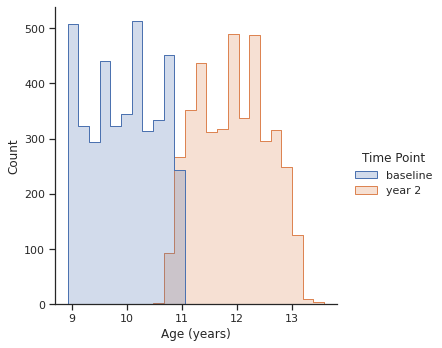

In [17]:
data_age = ((age_month / 12).reset_index()
            .rename(columns={'eventname':'Time Point'})
            .replace({abcd.EVENTS[0]:'baseline', abcd.EVENTS[1]:'year 2'}))

g = sns.displot(data_age, x='interview_age', hue='Time Point', element='step')
g.set_xlabels('Age (years)')
plt.show()

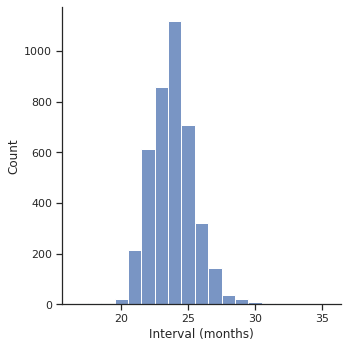

In [18]:
g = sns.displot(age_month_diff, discrete=True)
g.set_xlabels('Interval (months)')
plt.show()

### Sex

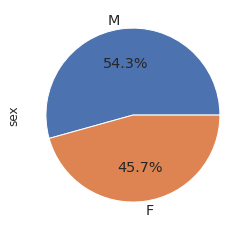

In [19]:
sex = covariates.loc[scon.index, 'sex'].xs(abcd.EVENTS[1], level='eventname')

ax = sex.value_counts().plot.pie(autopct='%1.1f%%', textprops={'size':'large'})
plt.show()

### Race

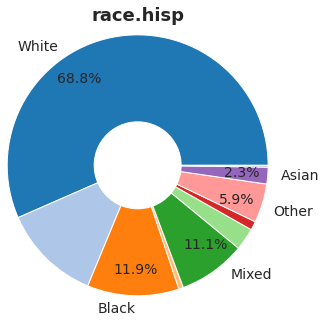

In [20]:
racehisp = covariates.loc[scon.index, ['race', 'hisp']].xs(abcd.EVENTS[1], level='eventname')

outer_counts = racehisp.dropna()['race'].value_counts()
inner_counts = racehisp.value_counts(sort=False).loc[outer_counts.index, ['No', 'Yes']]
inner_colors = plt.get_cmap('tab20')(np.arange(len(inner_counts)))

fig, ax = plt.subplots()
ax.pie(outer_counts, radius=1.5, wedgeprops={'width':0, 'edgecolor':'w'},
       labels=outer_counts.index, autopct='%1.1f%%', pctdistance=0.8,
       textprops={'size':14})
ax.pie(inner_counts, radius=1.5, wedgeprops={'width':1, 'edgecolor':'w'},
       colors=inner_colors)
ax.set_title('race.hisp', pad=36, fontdict={'weight':'bold', 'size':18})
plt.show()

### Mean Framewise Displacement

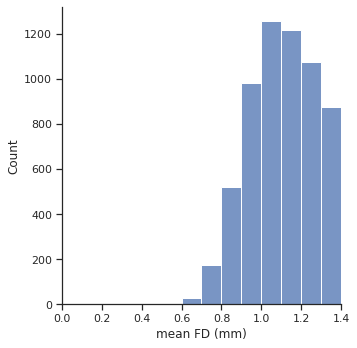

In [21]:
g = sns.displot(sc_extra['meanmotion'], binwidth=0.1, binrange=(0, 1.4))
g.set(xlim=(0, 1.4))
g.set_xlabels('mean FD (mm)')
plt.show()

## Difference

### Group

In [22]:
scon_groups = (scon.groupby(level='eventname').mean()
               .rename(index={abcd.EVENTS[0]: 'Baseline',
                              abcd.EVENTS[1]: 'Year 2'})
               .rename_axis('group').sort_index())

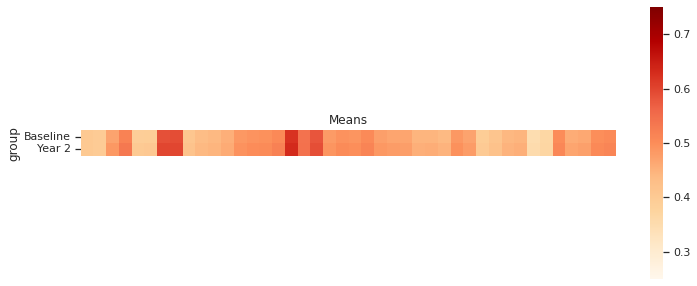

In [23]:
fig, ax = plt.subplots(figsize=(12,5))

ax = sns.heatmap(scon_groups, ax=ax, square=True, cmap='OrRd', vmin=0.25, vmax=0.75)
ax.set_title('Means')
ax.set_xticks([])
plt.show()

In [24]:
d = scon_groups.diff().dropna().reset_index(drop=True)

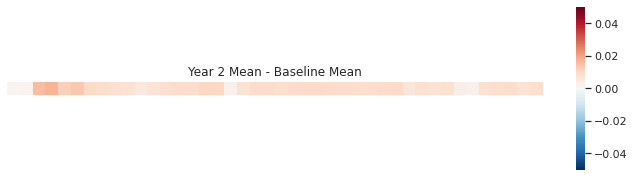

In [25]:
fig, ax = plt.subplots(figsize=(12,3))

ax = sns.heatmap(scon_groups.diff().dropna().reset_index(drop=True),
                 ax=ax, square=True, cmap='RdBu_r', vmin=-0.05, vmax=0.05)
ax.set_title('Year 2 Mean - Baseline Mean')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Longitudinal

In [26]:
dSC = (scon.groupby(level=0).diff().dropna().droplevel(1)
       .divide(age_month_diff / 12, axis=0))

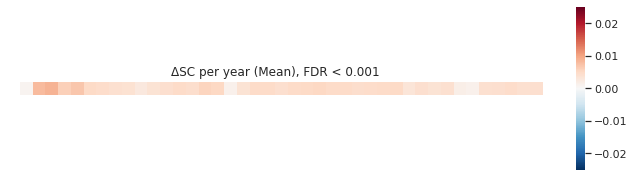

In [27]:
tstats, pvals = stats.ttest_1samp(dSC, 0, nan_policy='omit')
ttest_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(dSC.mean().mask(~ttest_fdr[0], np.nan).to_frame().T,
                 ax=ax, square=True, cmap='RdBu_r', vmin=-0.025, vmax=0.025)
ax.set_title('ΔSC per year (Mean), FDR < 0.001')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Residualized

In [28]:
confounds = sc_extra[['meanmotion']].join(covariates[['sex', 'race', 'hisp']])
scon_resid = residual.residualize(scon, sm.OLS, confounds, n_procs=4)

In [29]:
dSC_resid = (scon_resid.groupby(level=0).diff().dropna().droplevel(1)
             .divide(age_month_diff / 12, axis=0))

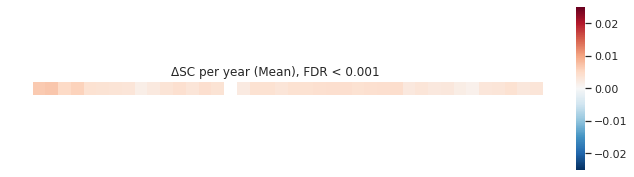

In [30]:
tstats, pvals = stats.ttest_1samp(dSC_resid, 0, nan_policy='omit')
ttest_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(dSC_resid.mean().mask(~ttest_fdr[0], np.nan).to_frame().T,
                 ax=ax, square=True, cmap='RdBu_r', vmin=-0.025, vmax=0.025)
ax.set_title('ΔSC per year (Mean), FDR < 0.001')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Linear Mixed Effects (LONG)

In [ ]:
exog = (sc_extra[['meanmotion']].join(age_month / 12)
        .join(covariates[['sex', 'race', 'hisp']]))
groups = scon.index.to_frame()[abcd.INDEX[0]]

with warnings.catch_warnings():
    warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
    scon_lme = residual.residualize(
        scon, sm.MixedLM, exog,
        groups=groups, method=['bfgs', 'cg', 'nm'],
        return_results=True, n_procs=4
    )

In [33]:
scon_beta = scon_lme.apply(lambda r: r.params['interview_age'])
pvals = scon_lme.apply(lambda r: r.pvalues['interview_age'])
p_fdr = multipletests(pvals, alpha=0.001, method='fdr_bh')

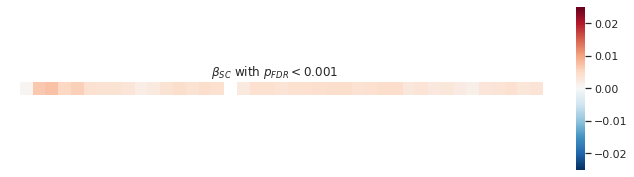

In [35]:
fig, ax = plt.subplots(figsize=(12,3))
ax = sns.heatmap(scon_beta.mask(~p_fdr[0], np.nan).to_frame().T,
                 ax=ax, square=True, cmap='RdBu_r', vmin=-0.025, vmax=0.025)
ax.set_title(r'$\beta_{SC}$ with $p_{FDR} < 0.001$')
ax.set_xticks([])
ax.set_yticks([])
plt.show()